# 순환 신경망(Recurrent Neural Network, RNN)

- 루프(loop)를 가진 신경망의 한 종류

- 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 상태(state)에 저장

<img src="https://miro.medium.com/max/627/1*go8PHsPNbbV6qRiwpUQ5BQ.png">

<sub>출처: https://towardsdatascience.com/understanding-rnn-and-lstm-f7cdf6dfc14e</sub>

## 순환 신경망 레이어 (RNN Layer)

- 입력: `(timesteps, input_features)`

- 출력: `(timesteps, output_features)`

In [1]:
import numpy as np

In [2]:
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

sucessive_outputs = []

for input_t in inputs:
  output_t = np.tanh(np.dot(W,input_t) + np.dot(U, state_t) + b)
  sucessive_outputs.append(output_t)
  state_t = output_t

final_output_sequence = np.stack(sucessive_outputs, axis=0)

## 케라스의 순환층
- `SimpleRNN` layer

- 입력: `(batch_size, timesteps, input_features)`

- 출력
  - `return_sequences`로 결정할 수 있음
  
  - 3D 텐서
    - 타임스텝의 출력을 모은 전체 시퀀스를 반환

    - `(batch_size, timesteps, output_features)`

  - 2D 텐서
    - 입력 시퀀스에 대한 마지막 출력만 반환

    - `(batch_size, output_features)`


In [3]:
from tensorflow.keras.layers import SimpleRNN, Embedding
from tensorflow.keras.models import Sequential

In [4]:
model = Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [5]:
model = Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


- 네트워크의 표현력을 증가시키기 위해 여러 개의 순환층을 차례대로 쌓는 것이 유용할 때가 있음

  - 이런 설정에서는 중간층들이 전체 출력 시퀀스를 반환하도록 설정

In [6]:
model = Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


## IMDB 데이터 적용

### 데이터 로드

In [7]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

In [16]:
num_words = 10000
max_len = 2000
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=num_words)
print(input_train.shape)
print(len(input_train))
print(len(input_test))

input_train = sequence.pad_sequences(input_train, maxlen=max_len)
input_test = sequence.pad_sequences(input_test, maxlen=max_len)
print(input_train)
print(input_test)

(25000,)
25000
25000
[[   0    0    0 ...   19  178   32]
 [   0    0    0 ...   16  145   95]
 [   0    0    0 ...    7  129  113]
 ...
 [   0    0    0 ...    4 3586    2]
 [   0    0    0 ...   12    9   23]
 [   0    0    0 ...  204  131    9]]
[[   0    0    0 ...   14    6  717]
 [   0    0    0 ...  125    4 3077]
 [   0    0    0 ...    9   57  975]
 ...
 [   0    0    0 ...   21  846 5518]
 [   0    0    0 ... 2302    7  470]
 [   0    0    0 ...   34 2005 2643]]


## 1
 - max_len = 10000

### 모델 구성

In [10]:
from tensorflow.keras.layers import Dense

In [11]:
model = Sequential()

model.add(Embedding(num_words, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


### 모델 학습


In [12]:
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 155s 990ms/step - loss: 0.5644 - acc: 0.7046 - val_loss: 0.8370 - val_acc: 0.5984
Epoch 2/10
157/157 [==============================] - 157s 997ms/step - loss: 0.3538 - acc: 0.8569 - val_loss: 0.3715 - val_acc: 0.8478
Epoch 3/10
157/157 [==============================] - 153s 975ms/step - loss: 0.2737 - acc: 0.8953 - val_loss: 0.3271 - val_acc: 0.8670
Epoch 4/10
157/157 [==============================] - 156s 996ms/step - loss: 0.2162 - acc: 0.9184 - val_loss: 0.3503 - val_acc: 0.8546
Epoch 5/10
157/157 [==============================] - 154s 984ms/step - loss: 0.1706 - acc: 0.9390 - val_loss: 0.4149 - val_acc: 0.8644
Epoch 6/10
157/157 [==============================] - 154s 984ms/step - loss: 0.1390 - acc: 0.9515 - val_loss: 0.4638 - val_acc: 0.7910
Epoch 7/10
157/157 [==============================] - 154s 982ms/step - loss: 0.1014 - acc: 0.9660 - val_loss: 0.4210 - val_acc: 0.8606
Epoch 8/10
157/157 [============================

### 시각화

In [13]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

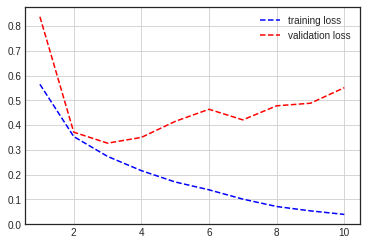

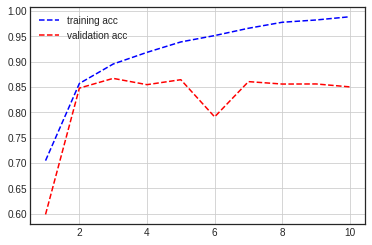

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,'b--',label='training loss')
plt.plot(epochs, val_loss,'r--',label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc,'b--',label='training acc')
plt.plot(epochs, val_acc,'r--',label='validation acc')
plt.grid()
plt.legend()

plt.show()


In [15]:
model.evaluate(input_test, y_test)

782/782 [==============================] - 62s 79ms/step - loss: 0.5726 - acc: 0.8446


[0.5726392269134521, 0.8446400165557861]

- 전체 시퀀스가 아니라 순서대로 500개의 단어만 입력했기 때문에 성능이 낮게 나옴

- SimpleRNN은 긴 시퀀스를 처리하는데 적합하지 않음

## 2

### 모델 구성

In [ ]:
from tensorflow.keras.layers import Dense

In [17]:
model = Sequential()

model.add(Embedding(num_words, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


### 모델 학습
 - max_len = 10000

In [18]:
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 346s 2s/step - loss: 0.5709 - acc: 0.7006 - val_loss: 0.4961 - val_acc: 0.7618
Epoch 2/10
157/157 [==============================] - 341s 2s/step - loss: 0.4121 - acc: 0.8274 - val_loss: 0.4021 - val_acc: 0.8310
Epoch 3/10
157/157 [==============================] - 341s 2s/step - loss: 0.3009 - acc: 0.8811 - val_loss: 0.4669 - val_acc: 0.8180
Epoch 4/10
157/157 [==============================] - 341s 2s/step - loss: 0.2379 - acc: 0.9090 - val_loss: 0.3430 - val_acc: 0.8668
Epoch 5/10
157/157 [==============================] - 341s 2s/step - loss: 0.1916 - acc: 0.9287 - val_loss: 0.4931 - val_acc: 0.7852
Epoch 6/10
157/157 [==============================] - 340s 2s/step - loss: 0.1440 - acc: 0.9489 - val_loss: 0.4119 - val_acc: 0.8352
Epoch 7/10
157/157 [==============================] - 340s 2s/step - loss: 0.1101 - acc: 0.9610 - val_loss: 0.5201 - val_acc: 0.8496
Epoch 8/10
157/157 [==============================] - 339s 2s/step - 

### 시각화

In [19]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

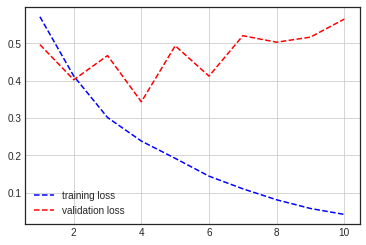

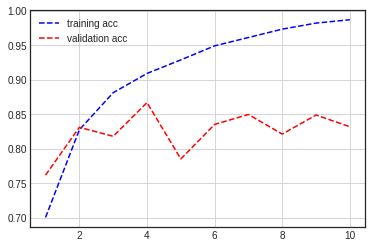

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,'b--',label='training loss')
plt.plot(epochs, val_loss,'r--',label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc,'b--',label='training acc')
plt.plot(epochs, val_acc,'r--',label='validation acc')
plt.grid()
plt.legend()

plt.show()


In [21]:
model.evaluate(input_test, y_test)

782/782 [==============================] - 113s 145ms/step - loss: 0.5717 - acc: 0.8296


[0.5717434883117676, 0.8295599818229675]

- 전체 시퀀스가 아니라 순서대로 500개의 단어만 입력했기 때문에 성능이 낮게 나옴

- SimpleRNN은 긴 시퀀스를 처리하는데 적합하지 않음

# LSTM과 GRU 레이어

- SimpleRNN은 실전에 사용하기엔 너무 단순

- SimpleRNN은 이론적으로 시간 $t$ 에서 이전의 모든 타임스텝의 정보를 유지할 수 있지만, 실제로는 긴 시간에 걸친 의존성은 학습할 수 없음

- 그래디언트 소실 문제(vanishing gradient problem)
  - 이를 방지하기 위해 LSTM, GRU 같은 레이어 등장



## LSTM(Long Short-Term Memory)
- 장단기 메모리 알고리즘

- 나중을 위해 정보를 저장함으로써 오래된 시그널이 점차 소실되는 것을 막아줌

  <img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png">

  <sub>출처: https://colah.github.io/posts/2015-08-Understanding-LSTMs/</sub>

## 예제로 보는 순환 신경망: Reuters 

- IMDB와 유사한 데이터셋(텍스트 데이터)

- 46개의 상호 배타적인 토픽으로 이루어진 데이터셋 
  - 다중 분류 문제


### 데이터셋 로드

In [ ]:
from tensorflow.keras.datasets import reuters

In [ ]:
num_words = 10000
(x_train, y_train), ( x_test, y_test) = reuters.load_data(num_words=num_words)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

2113536/2110848 [==============================] - 0s 0us/step
(8982,)
(8982,)
(2246,)
(2246,)


### 데이터 전처리 및 확인

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
max_len = 500

In [ ]:
pad_x_train = pad_sequences(x_train, maxlen = max_len)
pad_x_test = pad_sequences(x_test, maxlen = max_len)
print(len(pad_x_train))

8982


In [ ]:
pad_x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### 모델 구성
- LSTM 레이어도 SimpleRNN과 같이 `return_sequences` 인자 사용가능

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=64))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(46,activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 46)                1518      
Total params: 686,958
Trainable params: 686,958
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [ ]:
history = model.fit(pad_x_train, y_train,
                    batch_size=32, epochs=20,
                    validation_split=0.2)

Epoch 1/20
225/225 [==============================] - 47s 207ms/step - loss: 2.5516 - acc: 0.3531 - val_loss: 2.4079 - val_acc: 0.3450
Epoch 2/20
225/225 [==============================] - 46s 204ms/step - loss: 2.4090 - acc: 0.3534 - val_loss: 2.4072 - val_acc: 0.3450
Epoch 3/20
225/225 [==============================] - 46s 203ms/step - loss: 2.1106 - acc: 0.4540 - val_loss: 1.8396 - val_acc: 0.5331
Epoch 4/20
225/225 [==============================] - 46s 203ms/step - loss: 1.7681 - acc: 0.5375 - val_loss: 1.6842 - val_acc: 0.5648
Epoch 5/20
225/225 [==============================] - 46s 203ms/step - loss: 1.6100 - acc: 0.5761 - val_loss: 1.6232 - val_acc: 0.5910
Epoch 6/20
225/225 [==============================] - 46s 203ms/step - loss: 1.4671 - acc: 0.6270 - val_loss: 1.5766 - val_acc: 0.6043
Epoch 7/20
225/225 [==============================] - 46s 203ms/step - loss: 1.3947 - acc: 0.6450 - val_loss: 1.5420 - val_acc: 0.6099
Epoch 8/20
225/225 [==============================] - 4

### 시각화

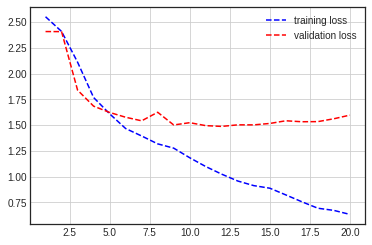

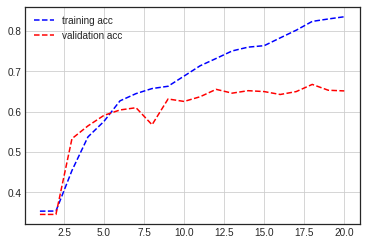

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,'b--',label='training loss')
plt.plot(epochs, val_loss,'r--',label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc,'b--',label='training acc')
plt.plot(epochs, val_acc,'r--',label='validation acc')
plt.grid()
plt.legend()

plt.show()


### 모델 평가


In [ ]:
model.evaluate(pad_x_test, y_test)

71/71 [==============================] - 5s 69ms/step - loss: 1.6775 - acc: 0.6367


[1.6774824857711792, 0.6366874575614929]

## IMDB 데이터셋 with LSTM

### 데이터 로드

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
num_words = 10000
max_len = 500
batch_size = 32

(pad_x_train, y_train), (pad_x_test, y_test) = imdb.load_data(num_words=num_words)
print(len(pad_x_train))
print(len(pad_x_test))

pad_x_train = sequence.pad_sequences(pad_x_train, maxlen=max_len)
pad_x_test = sequence.pad_sequences(pad_x_test, maxlen=max_len)
print(pad_x_train.shape)
print(pad_x_test.shape)

25000
25000
(25000, 500)
(25000, 500)


### 모델 구성

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

In [ ]:
model = Sequential()

model.add(Embedding(num_words, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [ ]:
history = model.fit(pad_x_train, y_train,
                    epochs=10, batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 15s 94ms/step - loss: 0.5029 - acc: 0.7595 - val_loss: 0.3583 - val_acc: 0.8454
Epoch 2/10
157/157 [==============================] - 14s 92ms/step - loss: 0.2993 - acc: 0.8832 - val_loss: 0.3030 - val_acc: 0.8746
Epoch 3/10
157/157 [==============================] - 14s 91ms/step - loss: 0.2312 - acc: 0.9125 - val_loss: 0.3043 - val_acc: 0.8700
Epoch 4/10
157/157 [==============================] - 14s 91ms/step - loss: 0.2032 - acc: 0.9244 - val_loss: 0.3177 - val_acc: 0.8774
Epoch 5/10
157/157 [==============================] - 14s 92ms/step - loss: 0.1749 - acc: 0.9345 - val_loss: 0.4201 - val_acc: 0.8646
Epoch 6/10
157/157 [==============================] - 14s 91ms/step - loss: 0.1579 - acc: 0.9442 - val_loss: 0.3039 - val_acc: 0.8720
Epoch 7/10
157/157 [==============================] - 14s 91ms/step - loss: 0.1435 - acc: 0.9510 - val_loss: 0.3147 - val_acc: 0.8844
Epoch 8/10
157/157 [==============================] - 14s 92ms

### 시각화

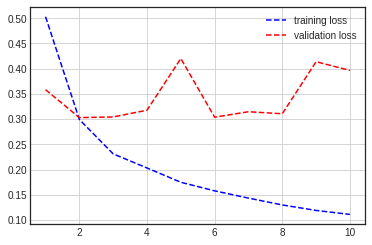

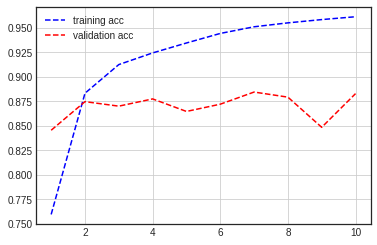

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,'b--',label='training loss')
plt.plot(epochs, val_loss,'r--',label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc,'b--',label='training acc')
plt.plot(epochs, val_acc,'r--',label='validation acc')
plt.grid()
plt.legend()

plt.show()

### 모델 평가

In [ ]:
model.evaluate(pad_x_test, y_test)

782/782 [==============================] - 24s 30ms/step - loss: 0.4746 - acc: 0.8578


[0.47463303804397583, 0.8578400015830994]

# Cosine 함수를 이용한 순환 신경망

In [ ]:
import numpy as np

In [ ]:
np.random.seed(111)

time = np.arange(30*12+1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5,
                            np.cos(2 * np.pi * month_time),
                            np.cos(2 * np.pi * month_time) + np.random.random(361))

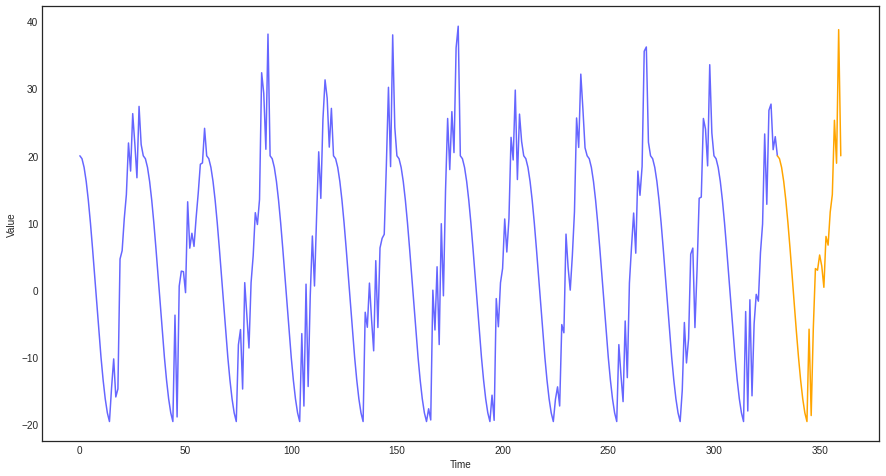

In [ ]:
plt.figure(figsize=(15,8))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0,30*11+1),
         time_series[:30*11+1],
         color='blue', alpha=0.6, label='Train Data')
plt.plot(np.arange(30*11, 30*12+1),
         time_series[30*11:],
         color='orange',label='Test Data')
plt.show()

### 데이터 전처리

In [ ]:
def make_data(time_series, n):
  x_train_full, y_train_full = list(), list()

  for i in range(len(time_series)):
    x = time_series[i:(i+n)]
    if (i+n) < len(time_series):
      x_train_full.append(x)
      y_train_full.append(time_series[i+n])
    else:
      break
  x_train_full, y_train_full = np.array(x_train_full), np.array(y_train_full)
  return x_train_full, y_train_full

In [ ]:
n = 10
x_train_full, y_train_full = make_data(time_series, n)

In [ ]:
print(x_train_full.shape)
print(y_train_full.shape)

(351, 10)
(351,)


In [ ]:
x_train_full = x_train_full.reshape(-1, n, 1)
y_train_full = y_train_full.reshape(-1, 1)

In [ ]:
print(x_train_full.shape)
print(y_train_full.shape)

(351, 10, 1)
(351, 1)


## 테스트 데이터셋 생성

In [ ]:
x_train = x_train_full[:30*11]
y_train = y_train_full[:30*11]

x_test = x_train_full[30*11:]
y_test = y_train_full[30*11:]

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(330, 10, 1) (330, 1)
(21, 10, 1) (21, 1)


## 데이터 확인

In [ ]:
sample_series = np.arange(100)
a,b = make_data(sample_series,10)

print(a[0])
print(b[0])

[0 1 2 3 4 5 6 7 8 9]
10


## 모델 구성

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense
from tensorflow.keras.models import Sequential

In [ ]:
def build_model(n):
  model = Sequential()

  model.add(SimpleRNN(units=32, activation='tanh', input_shape=(n,1)))
  model.add(Dense(1))

  model.compile(optimizer='adam',
                loss='mse')
  
  return model

In [ ]:
model = build_model(10)
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 32)                1088      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

In [ ]:
model.fit(x_train,y_train,
          epochs=100, batch_size=10)

Epoch 1/100
33/33 [==============================] - 0s 8ms/step - loss: 203.4843
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 157.1006
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 128.2632
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 112.6916
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 101.5369
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 92.3412
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 84.8488
Epoch 8/100
33/33 [==============================] - 0s 7ms/step - loss: 78.2236
Epoch 9/100
33/33 [==============================] - 0s 7ms/step - loss: 72.5034
Epoch 10/100
33/33 [==============================] - 0s 8ms/step - loss: 67.6491
Epoch 11/100
33/33 [==============================] - 0s 7ms/step - loss: 63.3227
Epoch 12/100
33/33 [==============================] - 0s 7ms/step - loss: 59.5881
Epoch 13/100
33/33 [

## 예측값 그려보기

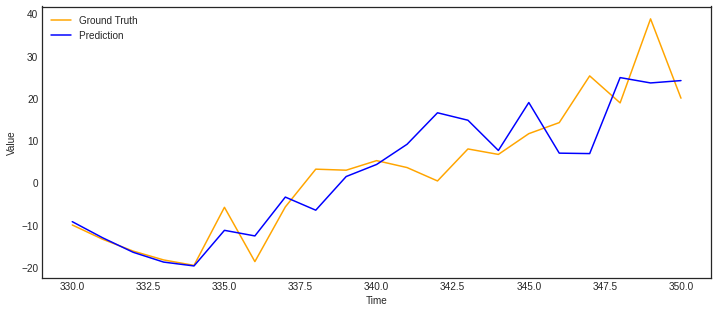

In [ ]:
prediction = model.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(prediction))

plt.figure(figsize=(12,5))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(pred_range, y_test.flatten(), color='orange', label='Ground Truth')
plt.plot(pred_range, prediction.flatten(), color='blue', label='Prediction ')
plt.legend()
plt.show()

## 모델 재구성 (2)
- LSTM 사용

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
def build_model2(n):
  model = Sequential()

  model.add(LSTM(units=64, return_sequences=True, input_shape=(n,1)))
  model.add(LSTM(32))
  model.add(Dense(1))

  model.compile(optimizer='adam',
                loss='mse')
  
  return model

In [ ]:
model_2 = build_model2(10)
model_2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


## 모델 재학습 및 예측값 그려보기

In [ ]:
model_2.fit(x_train,y_train,
          epochs=100, batch_size=12)

Epoch 1/100
28/28 [==============================] - 0s 7ms/step - loss: 216.7031
Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 160.4990
Epoch 3/100
28/28 [==============================] - 0s 7ms/step - loss: 115.3831
Epoch 4/100
28/28 [==============================] - 0s 8ms/step - loss: 91.6925
Epoch 5/100
28/28 [==============================] - 0s 7ms/step - loss: 75.6060
Epoch 6/100
28/28 [==============================] - 0s 7ms/step - loss: 64.7309
Epoch 7/100
28/28 [==============================] - 0s 7ms/step - loss: 56.3925
Epoch 8/100
28/28 [==============================] - 0s 7ms/step - loss: 50.8523
Epoch 9/100
28/28 [==============================] - 0s 7ms/step - loss: 45.8234
Epoch 10/100
28/28 [==============================] - 0s 7ms/step - loss: 42.5813
Epoch 11/100
28/28 [==============================] - 0s 7ms/step - loss: 39.9859
Epoch 12/100
28/28 [==============================] - 0s 7ms/step - loss: 37.2889
Epoch 13/100
28/28 [==

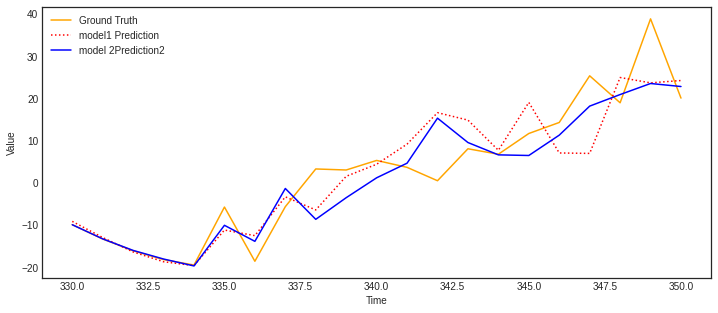

In [ ]:
prediction2 = model_2.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(prediction2))

plt.figure(figsize=(12,5))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(pred_range, y_test.flatten(), color='orange', label='Ground Truth')
plt.plot(pred_range, prediction.flatten(), 'r:', label='model1 Prediction ')
plt.plot(pred_range, prediction2.flatten(), color='blue', label='model 2Prediction2 ')
plt.legend()
plt.show()

## 모델 재구성(3)
- GRU 사용
  - LSTM 보다 더 쉬운 구조

In [ ]:
from tensorflow.keras.layers import GRU

In [ ]:
def build_model3(n):
  model = Sequential()

  model.add(GRU(units=30, return_sequences=True, input_shape=(n,1)))
  model.add(GRU(30))
  model.add(Dense(1))

  model.compile(optimizer='adam',
                loss='mse')
  
  return model

model_3 = build_model3(10)
model_3.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 10, 30)            2970      
_________________________________________________________________
gru_3 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 31        
Total params: 8,581
Trainable params: 8,581
Non-trainable params: 0
_________________________________________________________________


## 모델 재학습 및 예측값 그려보기

In [ ]:
model_3.fit(x_train,y_train,
            epochs=100,batch_size=12)

Epoch 1/100
28/28 [==============================] - 0s 7ms/step - loss: 202.9794
Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 144.5291
Epoch 3/100
28/28 [==============================] - 0s 7ms/step - loss: 113.7652
Epoch 4/100
28/28 [==============================] - 0s 7ms/step - loss: 93.4976
Epoch 5/100
28/28 [==============================] - 0s 7ms/step - loss: 79.9801
Epoch 6/100
28/28 [==============================] - 0s 7ms/step - loss: 70.6980
Epoch 7/100
28/28 [==============================] - 0s 7ms/step - loss: 64.1508
Epoch 8/100
28/28 [==============================] - 0s 7ms/step - loss: 58.7041
Epoch 9/100
28/28 [==============================] - 0s 6ms/step - loss: 53.9641
Epoch 10/100
28/28 [==============================] - 0s 7ms/step - loss: 49.8614
Epoch 11/100
28/28 [==============================] - 0s 7ms/step - loss: 46.1551
Epoch 12/100
28/28 [==============================] - 0s 7ms/step - loss: 42.8553
Epoch 13/100
28/28 [==

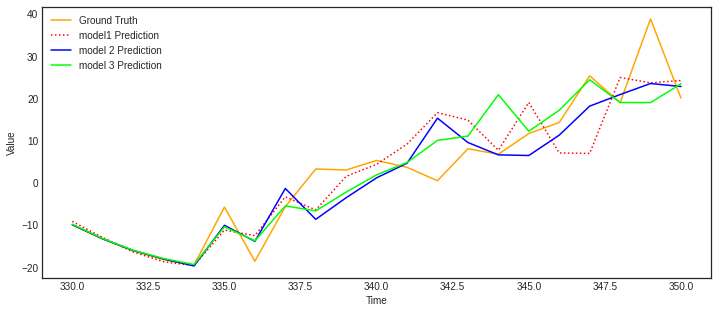

In [ ]:
prediction3 = model_3.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(prediction3))

plt.figure(figsize=(12,5))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(pred_range, y_test.flatten(), color='orange', label='Ground Truth')
plt.plot(pred_range, prediction.flatten(), 'r:', label='model1 Prediction ')
plt.plot(pred_range, prediction2.flatten(), color='blue', label='model 2 Prediction')
plt.plot(pred_range, prediction3.flatten(), color='lime', label='model 3 Prediction')
plt.legend()
plt.show()

# Conv1D 

- 텍스트 분류나 시계열 예측 같은 간단한 문제, 오디오 생성, 기계 번역 등의 문제에서 좋은 성능

- 타임스텝의 순서에 민감하지 X


- 2D Convolution
  - 지역적 특징을 인식

  <img src="https://missinglink.ai/wp-content/uploads/2019/03/2D-convolutional-example_2x-700x584.png" width="500">

- 1D Convolution
  - 문맥을 인식

  <img src="https://missinglink.ai/wp-content/uploads/2019/03/1D-convolutional-example_2x.png" width="500">

  <sub>출처: https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/</sub>

## Conv1D Layer
- 입력: `(batch_size, timesteps, channels)`

- 출력: `(batch_size, timesteps, filters)`

- 필터의 사이즈가 커져도 모델이 급격히 증가하지 않기 때문에 다양한 크기를 사용할 수 있음
- 데이터의 품질이 좋으면 굳이 크기를 달리하여 여러 개를 사용하지 않아도 될 수도 있음

## MaxPooling1D Layer
- 다운 샘플링 효과

- 단지 1차원형태로 바뀐 것 뿐

## GlovalMaxPooling Layer
- 배치차원을 제외하고 2차원 형태를 1차원 형태로 바꾸어주는 레이어

- Flatten layer로 대신 사용가능

## IMDB 데이터셋

### 데이터 로드 및 전처리

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [ ]:
num_words = 10000
max_len = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=num_words)

print(len(input_train))
print(len(input_test))

25000
25000


In [ ]:
pad_x_train = pad_sequences(input_train, maxlen=max_len)
pad_x_test = pad_sequences(input_test, maxlen=max_len)

print(pad_x_train.shape)
print(pad_x_test.shape)

(25000, 500)
(25000, 500)


### 모델 구성

In [ ]:
def build_model():
  model = Sequential()
  model.add(Embedding(input_dim=num_words, output_dim=32,
                      input_length=max_len))
  model.add(Conv1D(32,7,activation='relu'))
  model.add(MaxPooling1D(7))
  model.add(Conv1D(32,5,activation='relu'))
  model.add(MaxPooling1D(5))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(1,activation='sigmoid'))

  model.compile(optimizer=RMSprop(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics='acc')
  return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 32)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           7200      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 66, 32)            5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 32)            0         
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)               

### 모델 학습

In [ ]:
history = model.fit(pad_x_train, y_train,
                    batch_size=128,epochs=30,
                    validation_split=0.2)

Epoch 1/30
157/157 [==============================] - 4s 23ms/step - loss: 0.6931 - acc: 0.5077 - val_loss: 0.6923 - val_acc: 0.5500
Epoch 2/30
157/157 [==============================] - 3s 21ms/step - loss: 0.6907 - acc: 0.6152 - val_loss: 0.6907 - val_acc: 0.5668
Epoch 3/30
157/157 [==============================] - 3s 21ms/step - loss: 0.6871 - acc: 0.6192 - val_loss: 0.6878 - val_acc: 0.5404
Epoch 4/30
157/157 [==============================] - 3s 21ms/step - loss: 0.6798 - acc: 0.7138 - val_loss: 0.6756 - val_acc: 0.7084
Epoch 5/30
157/157 [==============================] - 3s 21ms/step - loss: 0.6593 - acc: 0.7613 - val_loss: 0.6437 - val_acc: 0.7564
Epoch 6/30
157/157 [==============================] - 3s 20ms/step - loss: 0.6104 - acc: 0.7825 - val_loss: 0.5780 - val_acc: 0.7870
Epoch 7/30
157/157 [==============================] - 3s 21ms/step - loss: 0.5320 - acc: 0.8062 - val_loss: 0.4990 - val_acc: 0.8102
Epoch 8/30
157/157 [==============================] - 3s 21ms/step - 

### 시각화

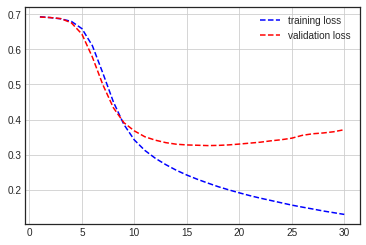

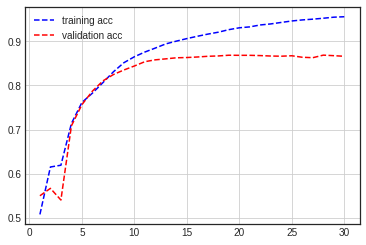

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,'b--',label='training loss')
plt.plot(epochs, val_loss,'r--',label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc,'b--',label='training acc')
plt.plot(epochs, val_acc,'r--',label='validation acc')
plt.grid()
plt.legend()

plt.show()

- 과적합이 일어났지만, 다른 옵티마이저 사용, 규제화를 걸어보는 등 다양하게 시도해볼 수 있음